In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as stats
from scipy.linalg import sqrtm

### Importing Data & Structure

In [2]:
directory = 'experiment_verysmall/'
file_name = directory + 'network_params/network.txt'
with open(file_name, 'r') as file:
    elist = [eval(line.strip()) for line in file]

G = nx.Graph()
G.add_weighted_edges_from(elist)
network = np.array(list(G.nodes))
N = len(network)

df = pd.read_csv('data_synth.csv')
df = df.drop(columns=['times'])
data = df.to_numpy()
T = len(data)
supply = np.tile(data[:,0], N)
demand = np.tile(data[:,1],N)

populations = np.loadtxt(directory + 'network_params/node_weights.txt', delimiter=',',dtype=float)/177924

### Define Covariance Structure

In [3]:
def clip_eigenvalues(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)
    eigenvalues = np.where(np.real(eigenvalues) < 0, -eigenvalues, eigenvalues)
    eigenvalues = np.real(eigenvalues)
    return np.real(eigenvectors @ np.diag(eigenvalues) @ np.linalg.inv(eigenvectors))

def get_covariance_matrix(G,N,T,alpha=0.5,trans_decay=1.0,time_decay=1.0):
    transportation_cov = alpha*np.exp(-nx.adjacency_matrix(G).toarray()/trans_decay)
    time_cov = (1-alpha)*np.exp(-np.abs(np.subtract.outer(np.arange(T), np.arange(T)))/time_decay)
    
    cov = transportation_cov[:,np.newaxis,:,np.newaxis] + time_cov[np.newaxis,:,np.newaxis,:]
    cov = cov.reshape(N*T, N*T)
    cov = clip_eigenvalues(cov)
    return cov

### Generate Samples

In [4]:
mean = np.zeros(N*T)
cov = get_covariance_matrix(G,N,T,alpha=0.9,trans_decay=30.0,time_decay=10.0)
rv = stats.multivariate_normal(mean,cov,allow_singular=True)
samples = rv.rvs(size=2)

In [32]:
scale = 1.5
supply_noise = scale*samples[0]
demand_noise = scale*samples[1]

total_supply = np.reshape(supply + supply_noise,(N,T))
total_demand = np.reshape(demand + demand_noise,(N,T))

for n in range(N):
    total_supply[n] *= populations[n]**0.95
    total_demand[n] *= populations[n]

data_network = np.array([total_supply,total_demand])
np.save(directory +'network_params/data_network',data_network)
np.save(directory + 'network_params/cov',cov)

### Plotting Results

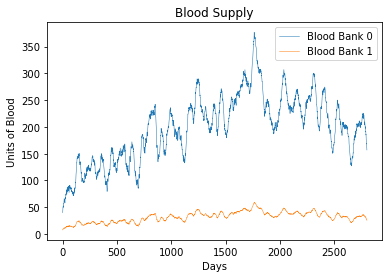

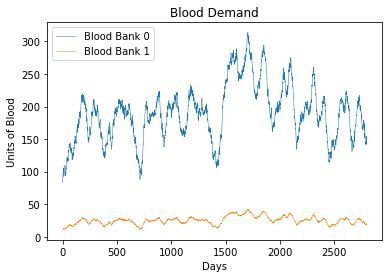

In [33]:
times = np.arange(len(data_network[0][0]))

for n in range(len(data_network[0])):
    plt.plot(times,data_network[0,n],label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Supply')
    plt.legend()

plt.show()

for n in range(len(data_network[1])):
    plt.plot(times,data_network[1,n],label='Blood Bank ' + str(n),linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Units of Blood')
    plt.title('Blood Demand')
    plt.legend()

plt.show()

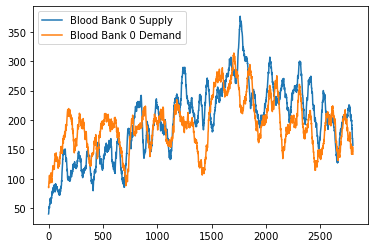

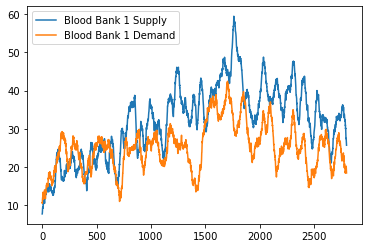

In [34]:
plt.plot(times,data_network[0,0],label="Blood Bank 0 Supply")
plt.plot(times,data_network[1,0],label="Blood Bank 0 Demand")
plt.legend()
plt.show()

plt.plot(times,data_network[0,1],label="Blood Bank 1 Supply")
plt.plot(times,data_network[1,1],label="Blood Bank 1 Demand")
plt.legend()
plt.show()

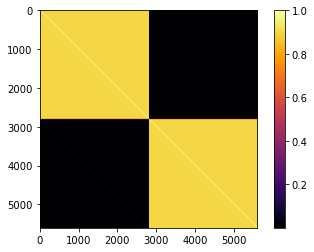

In [35]:
plt.imshow(np.real(cov),cmap='inferno')
plt.colorbar()